In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.4 MB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.graph_objs as go 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [3]:
calender= pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
calender.head(3)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [4]:
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [5]:
sales_dept = sales.groupby('dept_id').sum()
sales_dept.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
dept_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,...,3192,3523,3062,2461,2544,2657,2639,3169,3712,3185
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,...,5661,5792,6588,5247,4942,4734,4446,4974,5524,6473
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,...,19829,22692,24847,18443,17462,16241,16232,18561,22691,22996


In [6]:
sales_item = sales.groupby('item_id').sum()
sales_item.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,4,4,30,7,5,3,6,2,16,6
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,9,4,1,3,5,5,3,3,1
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,3,5,6,3,4,4,3,11,5


In [7]:

sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head(3)

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178,3764,5689
d_2,22758,3357,5634
d_3,17174,2682,3927


In [8]:
sales_cat['days'] =  sales_cat.index

# we got all of the Calender variables from columns
sales_cat.days

d_1          d_1
d_2          d_2
d_3          d_3
d_4          d_4
d_5          d_5
           ...  
d_1909    d_1909
d_1910    d_1910
d_1911    d_1911
d_1912    d_1912
d_1913    d_1913
Name: days, Length: 1913, dtype: object

In [9]:
sales_store = sales.groupby('store_id').sum()
sales_state = sales.groupby('state_id').sum()

In [10]:
sales_calender = calender.iloc[:,[0,2,3,4,5,6,7]]

sales_cat = pd.merge(sales_calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')

sales_cat['date'] = pd.to_datetime(sales_cat['date'])
sales_cat = sales_cat.set_index('date')


In [11]:
sales_cat = sales_cat.iloc[:,[-4,-3,-2]]
sales_cat.head(3)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634
2011-01-31,17174,2682,3927


In [12]:
sales_cat.tail(3)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2016-04-22,26704,4085,9728
2016-04-23,31927,4787,12248
2016-04-24,32654,4683,12458


In [13]:
fig = go.Figure(data = [
    go.Scatter(y=sales_cat['2011-01':'2016-04'].FOODS, x=sales_cat.index, name= 'Foods'), 
          go.Scatter(y=sales_cat['2011-01':'2016-04'].HOBBIES, x=sales_cat.index, name = 'Hobbies'),
          go.Scatter(y=sales_cat['2011-01':'2016-04'].HOUSEHOLD, x=sales_cat.index, name = 'Household')
])

fig.update_layout(title_text="Sales by Category")
fig.show()

Big part of Sales occur by Foods

<AxesSubplot:>

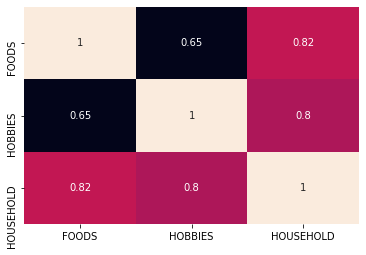

In [14]:
sns.heatmap(sales_cat[['FOODS','HOBBIES','HOUSEHOLD']].corr(), annot = True,  cbar=False)

In [15]:
sales_cat_monthly = sales_cat.iloc[:,[0,1,2]].resample('M').sum()[2:-1] #mensal resampling
sales_cat_weekly = sales_cat.iloc[:,[0,1,2]].resample('W').sum()[8:-1] #weekly resampling
sales_cat_bimonthly = sales_cat.iloc[:,[0,1,2]].resample('2M').sum()[1:-1] #bimonthy resamply

In [16]:
    lists = ['FOODS','HOBBIES','HOUSEHOLD']

    for i in lists:
        fig = go.Figure(data = [
            go.Scatter(y = sales_cat_monthly[i],x = sales_cat_monthly[i].index,name = i)
        ])
        fig.update_layout(title_text=i)
        fig.show()

In [17]:
#Decomposition

**************** Monthly *************


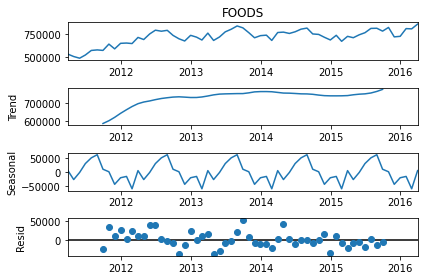

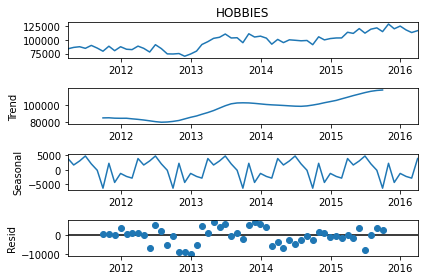

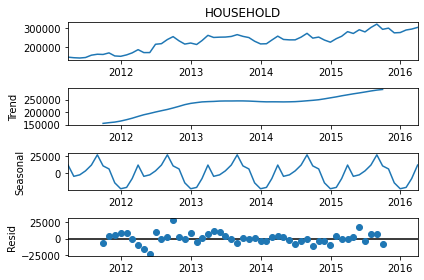

In [18]:
 lists = ['FOODS','HOBBIES','HOUSEHOLD']
print('**************** Monthly *************')
for i in lists:
    
        sm.tsa.seasonal_decompose(sales_cat_monthly[i],period = 12).plot()


**************** Weekly *************


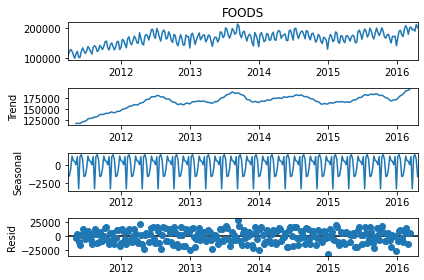

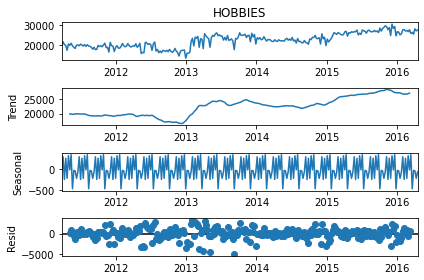

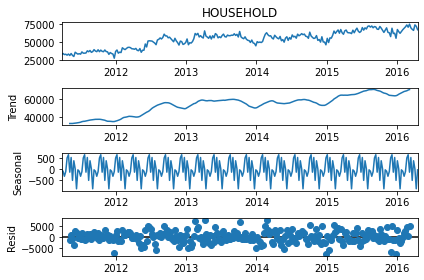

In [19]:
 lists = ['FOODS','HOBBIES','HOUSEHOLD']
print('**************** Weekly *************')
for i in lists:
    
        sm.tsa.seasonal_decompose(sales_cat_weekly[i],period = 12).plot()


In [20]:
# it was clearly observed that our series are Seasonal

In [21]:
def acf_pacf(df,columns,lag):

    plot_acf(df[columns],lags = lag,title = columns)
    plot_pacf(df[columns],lags = lag, title = columns)
    
    
    plt.show()

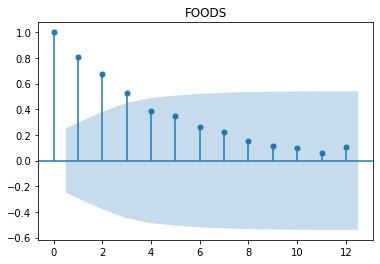

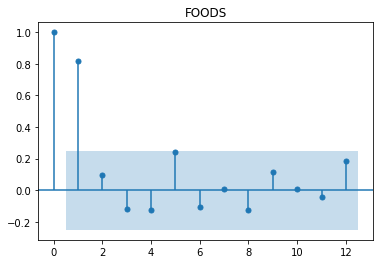

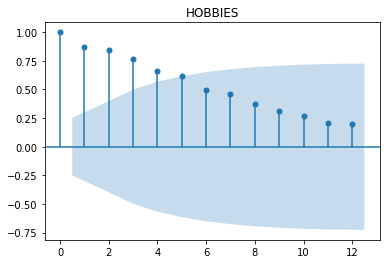

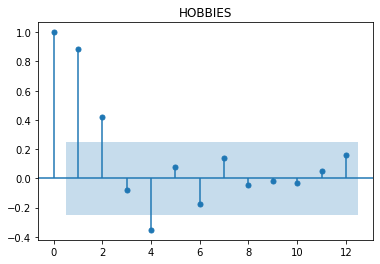

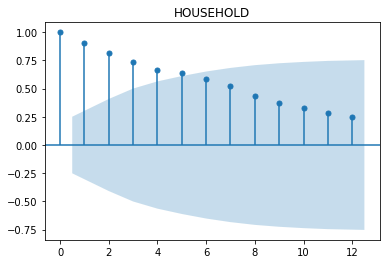

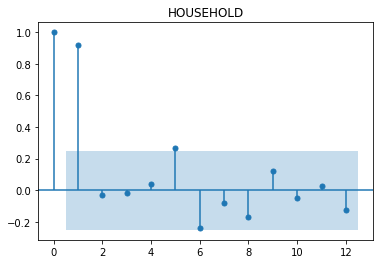

In [22]:
for i in lists:
    acf_pacf(sales_cat_monthly,i,12)

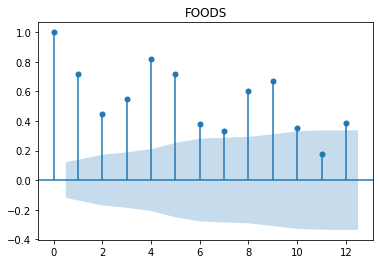

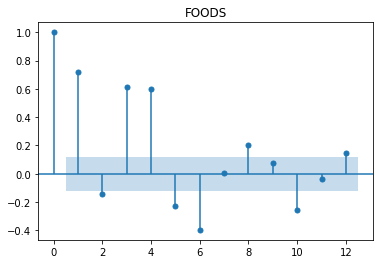

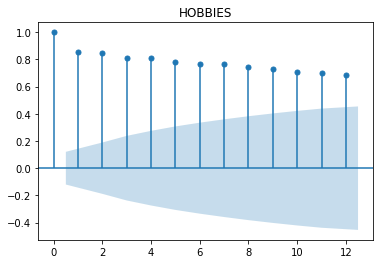

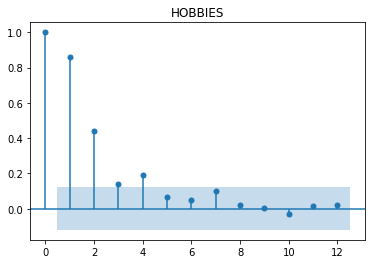

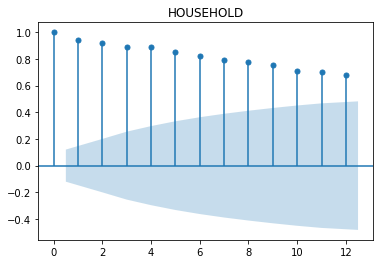

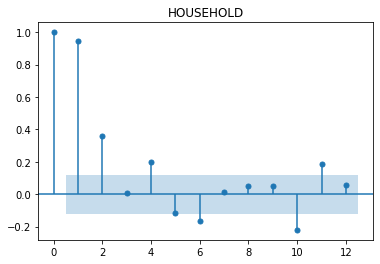

In [23]:
for i in lists:
    acf_pacf(sales_cat_weekly,i,12)

In [24]:
#it seems that i will continue on Monthly Series

In [25]:

 lists = ['FOODS','HOBBIES','HOUSEHOLD']
    
for i in lists:
     
        print('P values for {} is = {}'.format(i,adfuller(sales_cat_monthly[i], autolag='AIC')[1]))  




P values for FOODS is = 0.04369588721506289
P values for HOBBIES is = 0.7797828858576406
P values for HOUSEHOLD is = 0.4745840119557869


In [26]:
# The Food is Stationary but the others need to be implement

In [27]:
sales_cat_monthly_food  = sales_cat_monthly.iloc[:,0]

In [28]:
 sales_cat_monthly = sales_cat_monthly.iloc[:,1:3]

In [29]:
deneme = sales_cat_monthly.diff().dropna()

In [30]:
for i in ['HOBBIES','HOUSEHOLD']:
    print('P values for {} is = {}'.format(i,adfuller(deneme[i], autolag='AIC')[1]))

P values for HOBBIES is = 4.240864675751145e-23
P values for HOUSEHOLD is = 0.5549589106439722


In [31]:
#The food is stationary
sales_cat_monthly_hobbies = deneme.iloc[:,0] 

In [32]:
sales_cat_monthly_household = sales_cat_monthly.iloc[:,1]
# we will get salesc_cat_monthly_household without transformation because with Log,diff() 
#and df.shift(1)/df methods could not find p < 0.05

In [33]:
#Let start with Food
model_food = pm.auto_arima(sales_cat_monthly_food,
                     seasonal = True,m = 12,
                     d=1,D=1,
                     start_p = 1,start_q = 1,
                     end_p = 10, end_q =10,
                     trace = True,
                     error_action = 'ignore',
                     suppress_warnings=True)

model_food.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1152.516, Time=1.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1155.152, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1155.603, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1154.703, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1155.238, Time=0.17 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1154.466, Time=1.45 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1154.469, Time=1.98 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1153.606, Time=0.72 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1155.053, Time=1.06 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1156.368, Time=3.00 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1152.623, Time=0.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1153.284, Time=0.29 sec
 ARIMA(2,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   61
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -569.115
Date:                              Fri, 30 Apr 2021   AIC                           1148.230
Time:                                      04:41:15   BIC                           1157.586
Sample:                                           0   HQIC                          1151.766
                                               - 61                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0223      0.170      0.131      0.896      -0.312       0.356
ar.L2         -0.2152      0.199     -1.082      0.279      -0.605       0.175
ar.S.L12       0.5233      0.320      1.635      0.102      -0.104       1.151
ma.S.L12      -0.8685      0.492     -1.766      0.077      -1.832       0.095
sigma2      1.413e+09   4.44e-10   3.18e+18      0.000    1.41e+09    1.41e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.92   Prob(JB):                         0.66
Heteroskedasticity (H):               1.02   Skew:                            -0.16
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+34. Standard errors may be unstable.
"""

In [34]:
model_food = sm.tsa.statespace.SARIMAX(sales_cat_monthly_food,order = (2,1,0),seasonal_order = (1,1,1,12),trend = 'c')
results_food = model_food.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



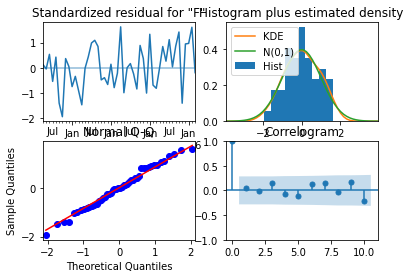

In [35]:
results_food.plot_diagnostics()
plt.show()


In [36]:
food_predict = results_food.predict(start=50,end= 65)

In [37]:
fig = go.Figure(data = [
    go.Scatter(y=sales_cat_monthly_food,x = sales_cat_monthly_food.index),
    go.Scatter(y=food_predict,x= food_predict.index)
])

fig.update_layout(title_text= 'Food')
fig.show()

In [38]:
# We will continue for household but we will close difference
#because we transformed it to stationary with diff() method
model_hobbies = pm.auto_arima(sales_cat_monthly_hobbies,
                     seasonal = True,m = 12,
                     d=1,D=1,
                     start_p = 1,start_q = 1,
                     end_p = 10, end_q =10,
                     trace = True,
                     error_action = 'ignore',
                     suppress_warnings=True)

model_hobbies.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1015.370, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=980.456, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=992.261, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=982.218, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=981.254, Time=0.24 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=979.629, Time=0.11 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=981.368, Time=0.33 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=981.950, Time=0.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=968.758, Time=0.16 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=981.593, Time=0.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=970.682, Time=0.31 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -479.319
Date:                            Fri, 30 Apr 2021   AIC                            968.637
Time:                                    04:41:33   BIC                            977.888
Sample:                                         0   HQIC                           972.118
                                             - 60                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2174      0.261     -0.833      0.405      -0.729       0.294
ar.L2          0.1556      0.269      0.579      0.562      -0.371       0.682
ma.L1         -0.9486      0.379     -2.500      0.012      -1.692      -0.205
ma.S.L12      -0.6697      0.349     -1.921      0.055      -1.353       0.013
sigma2      5.386e+07   4.01e-09   1.34e+16      0.000    5.39e+07    5.39e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.65   Prob(JB):                         0.91
Heteroskedasticity (H):               0.50   Skew:                            -0.12
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+32. Standard errors may be unstable.
"""

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



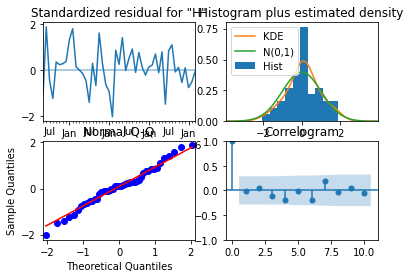

In [39]:
model_hobbies = sm.tsa.statespace.SARIMAX(sales_cat_monthly_hobbies,order = (2,1,1),seasonal_order = (0,1,1,12),trend = 'c')
results_hobbies = model_hobbies.fit()
results_hobbies.plot_diagnostics()
plt.show()


In [40]:
hobbies_predict = results_hobbies.predict(start = 50, end = 65)
values_predict = np.cumsum(hobbies_predict) + sales_cat_monthly.iloc[-1,0]

In [41]:

sales_cat_monthly_hobbies = sales_cat_monthly.iloc[:,0]

fig = go.Figure(data = [
    go.Scatter(y=sales_cat_monthly_hobbies,x = sales_cat_monthly_hobbies.index),
    go.Scatter(y=values_predict,x= values_predict.index)
])

fig.update_layout(title_text= 'Hobbies')
fig.show()

In [42]:

model_household = pm.auto_arima(sales_cat_monthly_household,
                     seasonal = True,m = 12,
                     d=1,D=1,
                     start_p = 1,start_q = 1,
                     end_p = 10, end_q =10,
                     trace = True,
                     error_action = 'ignore',
                     suppress_warnings=True)

model_household.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1057.977, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1058.002, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1056.895, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1060.491, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1057.128, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1057.901, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1058.006, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1060.911, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1059.114, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1057.048, Time=0.13 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1061.318, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -525.448
Date:                            Fri, 30 Apr 2021   AIC                           1056.895
Time:                                    04:41:40   BIC                           1062.509
Sample:                                         0   HQIC                          1059.016
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0515      0.100     -0.516      0.606      -0.247       0.144
ma.S.L12      -0.2993      0.106     -2.820      0.005      -0.507      -0.091
sigma2      1.805e+08   1.21e-10   1.49e+18      0.000     1.8e+08     1.8e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.25   Prob(JB):                         0.26
Heteroskedasticity (H):               0.37   Skew:                             0.40
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.24e+33. Standard errors may be unstable.
"""

In [43]:
model_households = sm.tsa.statespace.SARIMAX(sales_cat_monthly_household,order = (0,1,1),seasonal_order = (0,1,1,12),trend = 'c')
results_households = model_households.fit()
diff_forecast = results_households.predict(start = 50, end = 65)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



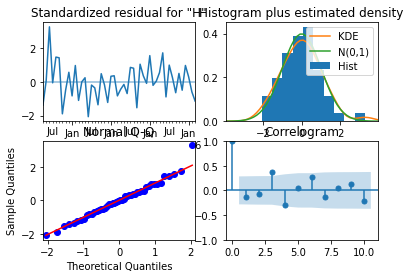

In [44]:
results_households.plot_diagnostics()
plt.show()

In [45]:
 # let the plot final chart

fig = go.Figure(data = [
    go.Scatter(y=sales_cat_monthly_household,x = sales_cat_monthly_household.index),
    go.Scatter(y=diff_forecast,x= diff_forecast.index)
])

fig.update_layout(title_text= 'Household')
fig.show()